# P60 Gitterschwingungen in Festkörpern

### Import libaries

In [ ]:
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import scipy as sp
import numpy as np
import seaborn as sns

from matplotlib.ticker import FuncFormatter
from matplotlib.colors import TABLEAU_COLORS, same_color
from scipy.optimize import curve_fit
from scipy.stats import linregress
from numpy import sqrt


%matplotlib inline

### Set sytle parameters

In [ ]:
#plt.style.available[:30]

plt.style.use('default')
plt.rcParams['text.usetex'] = False
plt.rcParams['mathtext.default'] = 'regular'


### Get and set colors

In [ ]:
# Get the color cycle
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

print(colors)


### Define Lorentzians and FWHM functions

In [ ]:
# Lorentz function
def lorentzian(x, x0, gamma, a, y0):
    return a * gamma**2 / ((x - x0)**2 + gamma**2) + y0

# Calculate Full Width at Half Maximum (FWHM) for Lorentzian
def lorentzian_fwhm(gamma):
    return 2 * gamma

# double Lorentzian function
def double_lorentzian(x, x01, gamma1, a1, x02, gamma2, a2 , y0):
    L1 = (a1 * (gamma1**2 / ((x - x01)**2 + gamma1**2)))
    L2 = (a2 * (gamma2**2 / ((x - x02)**2 + gamma2**2)))
    return L1 + L2 + y0

# sum of 3 lorentzians
def three_lorentzian(x, x01, gamma1, a1, x02, gamma2, a2, x03, gamma3, a3, y0):
    L1 = a1 * (gamma1**2 / ((x - x01)**2 + gamma1**2))
    L2 = a2 * (gamma2**2 / ((x - x02)**2 + gamma2**2))
    L3 = a3 * (gamma3**2 / ((x - x03)**2 + gamma3**2))
    return L1 + L2 + L3 + y0


# sum of 4 lorentzians
def four_lorentzian(x, x01, gamma1, a1, x02, gamma2, a2, x03, gamma3, a3, x04, gamma4, a4, y0):
    L1 = a1 * (gamma1**2 / ((x - x01)**2 + gamma1**2))
    L2 = a2 * (gamma2**2 / ((x - x02)**2 + gamma2**2))
    L3 = a3 * (gamma3**2 / ((x - x03)**2 + gamma3**2))
    L4 = a4 * (gamma4**2 / ((x - x04)**2 + gamma4**2))
    return L1 + L2 + L3 + L4 + y0


# sum of 5 lorentzians
def five_lorentzian(x, x01, gamma1, a1, x02, gamma2, a2, x03, gamma3, a3, x04, gamma4, a4, x05, gamma5, a5, y0):
    L1 = a1 * (gamma1**2 / ((x - x01)**2 + gamma1**2))
    L2 = a2 * (gamma2**2 / ((x - x02)**2 + gamma2**2))
    L3 = a3 * (gamma3**2 / ((x - x03)**2 + gamma3**2))
    L4 = a4 * (gamma4**2 / ((x - x04)**2 + gamma4**2))
    L5 = a5 * (gamma5**2 / ((x - x05)**2 + gamma5**2))
    return L1 + L2 + L3 + L4 + L5 + y0


# Fitting Lorentzian to data in specific range
def n_lorentzians_fit (df, function, xmin, xmax, p0):
    df_region = (df['Wavenumber'] > xmin) & (df['Wavenumber'] < xmax)
    xdata = df['Wavenumber'][df_region]
    ydata = df['Intensity'][df_region]
    params, cov = curve_fit(function, xdata, ydata, p0)
    perr = np.sqrt(np.diag(cov))

    return xdata, params, perr


# Fitting Lorentzian to data in specific range shifted
def n_lorentzians_fit_shifted (df, function, xmin, xmax, p0):
    df_region = (df['Wavenumber_shifted'] > xmin) & (df['Wavenumber_shifted'] < xmax)
    xdata = df['Wavenumber_shifted'][df_region]
    ydata = df['Intensity'][df_region]
    params, cov = curve_fit(function, xdata, ydata, p0)
    perr = np.sqrt(np.diag(cov))

    return xdata, params, perr

### Import data Si (100)

In [ ]:
file_path_si100_parallel = r'C:\Fortgeschrittenenpraktikum\P60\Auswertung\Messwerte\si100 polarisation 0grad\\'
file_path_si100_perpendicular = r'C:\Fortgeschrittenenpraktikum\P60\Auswertung\Messwerte\si100 polarisation 90grad\\'


file_names = ['si100_0grad.txt', 'si100_15grad.txt', 'si100_30grad.txt', 'si100_45grad.txt', 
              'si100_60grad.txt', 'si100_75grad.txt', 'si100_90grad.txt',
              'si100_105grad.txt', 'si100_120grad.txt', 'si100_135grad.txt', 
              'si100_150grad.txt', 'si100_165grad.txt', 'si100_180grad.txt']

dataframes_si100_parallel = []
dataframes_si100_perpendicular = []


for file in file_names:
    df = pd.read_csv(file_path_si100_parallel + file, sep=r'\s+', names=['Wavenumber', 'Intensity'])
    dataframes_si100_parallel.append(df)

    
for file in file_names:
    df = pd.read_csv(file_path_si100_perpendicular + file, sep=r'\s+', names=['Wavenumber', 'Intensity'])
    dataframes_si100_perpendicular.append(df)


#dataframes_si100_perpendicular[0].head()

### Importing data Si (111)

In [ ]:
file_path_si111 = r'C:\Fortgeschrittenenpraktikum\P60\Auswertung\Messwerte\si111\\'

df_si111_parallel = pd.read_csv(file_path_si111 + 'si111_0grad_polarisiert.txt', sep=r'\s+', names=['Wavenumber', 'Intensity'])
df_si111_perpendicular = pd.read_csv(file_path_si111 + 'si111_90grad_polarisiert.txt', sep=r'\s+', names=['Wavenumber', 'Intensity'])


### Calculating Wavenumber shift and apply to data

In [ ]:
# Calculating Wavenumber shift by fitting lorentzian to Rayleigh-Peaks of Si (100) and Si (111)

rayleigh_x0 = []

# Si (100) parallel
for i in range(13):
    _, params, _ = n_lorentzians_fit(dataframes_si100_parallel[i], lorentzian, -15, 10, p0=None)
    rayleigh_x0.append(params[0])

# Si (100) perpendicular
for i in range(13):
    _, params, _ = n_lorentzians_fit(dataframes_si100_perpendicular[i], lorentzian, -15, 10, p0=None)
    rayleigh_x0.append(params[0])


# Si (111) parallel and perpendicular
_, params_si111_par, _ =n_lorentzians_fit(df_si111_parallel, lorentzian, -15, 10, p0=None)
_, params_si111_per, _ =n_lorentzians_fit(df_si111_perpendicular, lorentzian, -15, 10, p0=None)

rayleigh_x0.append(params_si111_par[0])
rayleigh_x0.append(params_si111_per[0])


wavenumber_shift = np.mean(rayleigh_x0)
print(wavenumber_shift)


for i in range(13):
    dataframes_si100_parallel[i]['Wavenumber_shifted'] = dataframes_si100_parallel[i]['Wavenumber'] - wavenumber_shift
    dataframes_si100_perpendicular[i]['Wavenumber_shifted'] = dataframes_si100_perpendicular[i]['Wavenumber'] - wavenumber_shift




# Si (100) determine x- and y-axis

### Testing some stuff

In [ ]:
%matplotlib inline

dfv = 2

# Define linespace for better lorentzian fit
x = np.linspace(-20, 1200, 2440)

# Select rayleigh peak region to find amplitude for inital guess
rayleigh_peak_region = (dataframes_si100_parallel[dfv]['Wavenumber'] > -14) & (dataframes_si100_parallel[dfv]['Wavenumber'] < 4)
rayleigh_amplitude = dataframes_si100_parallel[dfv]['Intensity'][rayleigh_peak_region].max()

# Antistokes peak region
antistokes_peak_region = (dataframes_si100_parallel[dfv]['Wavenumber'] > 505) & (dataframes_si100_parallel[dfv]['Wavenumber'] < 530)


# Initial guess: [center, width, amplitude]
p0 = [-4, 5, rayleigh_amplitude]

# Fit
x_data = dataframes_si100_parallel[dfv]['Wavenumber']
y_data = dataframes_si100_parallel[dfv]['Intensity']

params, cov = curve_fit(lorentzian, x_data, y_data, p0=p0, maxfev=10000)
params_as_par, cov_as_par = curve_fit(lorentzian, x_data[antistokes_peak_region], y_data[antistokes_peak_region])
params_as_per, cov_as_per = curve_fit(lorentzian, dataframes_si100_perpendicular[dfv]['Wavenumber'][antistokes_peak_region], dataframes_si100_perpendicular[dfv]['Intensity'][antistokes_peak_region])


# Example usage with fitted gamma parameter
fwhm = lorentzian_fwhm(params[1])
print(f"Full Width at Half Maximum (FWHM): {fwhm:.2f}")


# Plot fit
fig, ax = plt.subplots(figsize=(8,5), constrained_layout=True)


ax.plot(x_data, y_data, label='Data', marker='o', ls='', ms=3)
ax.plot(dataframes_si100_perpendicular[dfv]['Wavenumber'], dataframes_si100_perpendicular[dfv]['Intensity'], 
        label='senkrecht', marker='o', ms=3, ls='')

#ax.plot(x, lorentzian(x, *params), label='Lorentz Fit', linestyle='--')
ax.plot(x, lorentzian(x, *params_as_par))
ax.plot(x, lorentzian(x, *params_as_per))


ax.set_xlabel(r'Wellenzahl ($cm^{-1}$)')
ax.set_ylabel('Intensität (counts)')
ax.legend()


print("Fit parameters: x0 = {:.2f}, gamma = {:.2f}, a = {:.2f}".format(*params))



### Fitting Anti-Stokes and Normalize Intensities of Si (100) parallel

In [ ]:
Lorentzian_amplitudes = []
Lorentzian_amplitudes_error = []

for i in range(13):

    # Region and amplitude for inital fit
    antistokes_peak_region = (dataframes_si100_parallel[i]['Wavenumber_shifted'] > 500) & (dataframes_si100_parallel[i]['Wavenumber_shifted'] < 540)
    antistokes_amplitude = dataframes_si100_parallel[i]['Intensity'][antistokes_peak_region].max()
    background = dataframes_si100_parallel[i]['Intensity'][antistokes_peak_region].min()

    # Initial guess [center, width, amplitude]
    p0_antistokes = [521, 5 , antistokes_amplitude, background]

    # Fit with lorentzian
    x_data = dataframes_si100_parallel[i]['Wavenumber_shifted']
    y_data = dataframes_si100_parallel[i]['Intensity']
    params, cov = curve_fit(lorentzian, x_data, y_data, p0=p0_antistokes, maxfev=10000)

    # Amplitude and Error of lorentzian fit
    cov_err = np.sqrt(np.diag(cov))
    Lorentzian_amplitudes.append(params[2]+cov_err[2]) # amplitude+error to stay between 0-1 with errors
    Lorentzian_amplitudes_error.append(cov_err[2])



# Normilize Intensities, Amplitude fitted with lorentzian
norm = max(Lorentzian_amplitudes)
Lorentzian_amplitudes_normilized = Lorentzian_amplitudes/norm
Lorentzian_amplitudes_normilized_error = Lorentzian_amplitudes_error/norm



### Fitting Anti-Stokes and Normalize Intensities of Si (100) perpendicular

In [ ]:
Lorentzian_amplitudes_per = []
Lorentzian_amplitudes_per_error = []

for i in range(13):

    # Region and amplitude for inital fit
    antistokes_peak_region_per = (dataframes_si100_perpendicular[i]['Wavenumber_shifted'] > 500) & (dataframes_si100_perpendicular[i]['Wavenumber_shifted'] < 540)
    antistokes_amplitude_per = dataframes_si100_perpendicular[i]['Intensity'][antistokes_peak_region_per].max()
    background = dataframes_si100_perpendicular[i]['Intensity'][antistokes_peak_region_per].min()

    # Initial guess [center, width, amplitude]
    p0_antistokes = [521, 10 , antistokes_amplitude_per, background]

    # Fit with lorentzian
    x_data = dataframes_si100_perpendicular[i]['Wavenumber_shifted']
    y_data = dataframes_si100_perpendicular[i]['Intensity']
    params, cov = curve_fit(lorentzian, x_data, y_data, p0=p0_antistokes)

    # Amplitude and error of lorentzian fit
    cov_per_error = np.sqrt(np.diag(cov))
    Lorentzian_amplitudes_per.append(params[2] + cov_per_error[2])
    Lorentzian_amplitudes_per_error.append(cov_per_error[2])


# Normilize Intensities, Amplitude fitted with lorentzian
del Lorentzian_amplitudes_per[1] #remove intensity at 15 degrees
del Lorentzian_amplitudes_per_error[1]

norm_per = max(Lorentzian_amplitudes_per)
Lorentzian_amplitudes_normilized_per = Lorentzian_amplitudes_per/norm_per
Lorentzian_amplitudes_normilized_per_error = Lorentzian_amplitudes_per_error/norm_per

### Plotting the data of Si (100) parallel

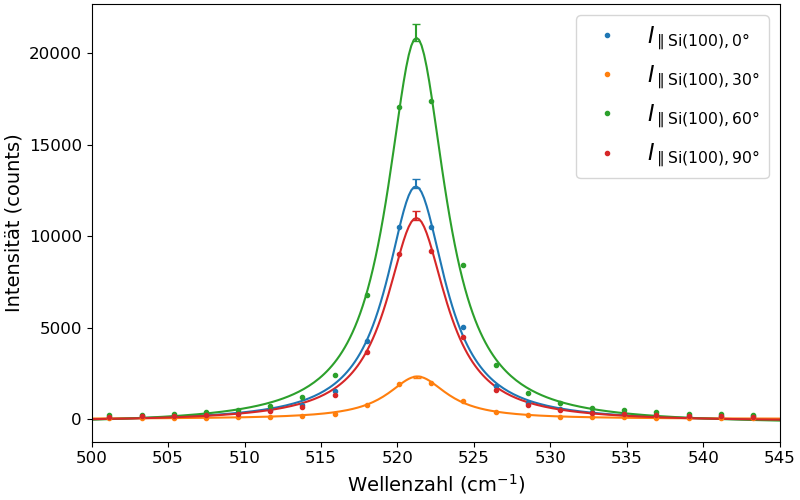

In [136]:
# Visualize Si (100) parallel data
%matplotlib widget


# define linespace for better fit visualization
antistokes_linespace = np.linspace(500, 550, 300)

# 0° shift Peak
xdata_si100_0, params_si100_0, params_si100_0_error = n_lorentzians_fit_shifted(dataframes_si100_parallel[0], lorentzian,
500, 540, p0=None)


# 30° shift Peak
xdata_si100_30, params_si100_30, params_si100_30_error = n_lorentzians_fit_shifted(dataframes_si100_parallel[1], lorentzian,
500, 540, p0=None)


# 60° shift Peak
xdata_si100_60, params_si100_60, params_si100_60_error = n_lorentzians_fit_shifted(dataframes_si100_parallel[2], lorentzian,
500, 540, p0=None)


# 90° shift Peak
xdata_si100_90, params_si100_90, params_si100_90_error = n_lorentzians_fit_shifted(dataframes_si100_parallel[3], lorentzian,
500, 540, p0=None)




# Plot figure
fig, ax = plt.subplots(figsize=(8,5), constrained_layout=True)

# 0°
ax.errorbar(dataframes_si100_parallel[0]['Wavenumber_shifted'], dataframes_si100_parallel[0]['Intensity'],
             label = r'$\mathit{I}_{\parallel Si(100), 0°}$', fmt='o', ms=3, c=colors[0])
ax.plot(antistokes_linespace, lorentzian(antistokes_linespace, *params_si100_0), c=colors[0])
ax.errorbar(params_si100_0[0], params_si100_0[2], yerr=params_si100_0_error[2], c=colors[0], capsize=3)

# 30°
ax.errorbar(dataframes_si100_parallel[1]['Wavenumber_shifted'], dataframes_si100_parallel[1]['Intensity'],
             label = r'$\mathit{I}_{\parallel Si(100), 30°}$', fmt='o', ms=3, c=colors[1])
ax.plot(antistokes_linespace, lorentzian(antistokes_linespace, *params_si100_30), c=colors[1])
ax.errorbar(params_si100_30[0], params_si100_30[2], yerr=params_si100_30_error[2], c=colors[1], capsize=3)


# 60°
ax.errorbar(dataframes_si100_parallel[2]['Wavenumber_shifted'], dataframes_si100_parallel[2]['Intensity'],
             label = r'$\mathit{I}_{\parallel Si(100), 60°}$', fmt='o', ms=3, c=colors[2],)
# ax.plot(antistokes_linespace, lorentzian(antistokes_linespace, *params_si100_60), c=colors[2])

ax.plot(antistokes_linespace, lorentzian(antistokes_linespace, *params_si100_60), c=colors[2])
ax.errorbar(params_si100_60[0], params_si100_60[2], yerr=params_si100_60_error[2], c=colors[2], capsize=3)


# 90°
ax.errorbar(dataframes_si100_parallel[3]['Wavenumber_shifted'], dataframes_si100_parallel[3]['Intensity'],
             label = r'$\mathit{I}_{\parallel Si(100), 90°}$', fmt='o', ms=3, c=colors[3])
ax.plot(antistokes_linespace, lorentzian(antistokes_linespace, *params_si100_90), c=colors[3])
ax.errorbar(params_si100_90[0], params_si100_90[2], yerr=params_si100_90_error[2], c=colors[3], capsize=3)




ax.set_xlabel(r'Wellenzahl ($cm^{-1}$)', fontsize = 14)
ax.set_ylabel('Intensität (counts)', fontsize = 14)
ax.tick_params(axis='both', which='major', labelsize=12)

ax.set_xlim(500,545)
ax.legend(fontsize=16)


### Plotting the data of Si (100) perpendicular

In [ ]:
# Visualize Si (100) perpendicular data
%matplotlib widget


# Define linespace for better fit visualization
antistokes_linespace = np.linspace(500, 550, 200)


# Fitting Peaks
# 0° shift Peak
xdata_si100_per_0, params_si100_per_0, params_si100_per_0_error = n_lorentzians_fit_shifted(dataframes_si100_perpendicular[0], lorentzian,
500, 540, p0=None)


# 30° shift Peak
xdata_si100_per_30, params_si100_per_30, params_si100_per_30_error = n_lorentzians_fit_shifted(dataframes_si100_perpendicular[1], lorentzian,
500, 540, p0=None)


# 60° shift Peak
xdata_si100_per_60, params_si100_per_60, params_si100_per_60_error = n_lorentzians_fit_shifted(dataframes_si100_perpendicular[2], lorentzian,
500, 540, p0=None)


# 90° shift Peak
xdata_si100_per_90, params_si100_per_90, params_si100_per_90_error = n_lorentzians_fit_shifted(dataframes_si100_perpendicular[3], lorentzian,
500, 540, p0=None)


# 120° shift Peak
xdata_si100_per_120, params_si100_per_120, params_si100_per_120_error = n_lorentzians_fit_shifted(dataframes_si100_perpendicular[4], lorentzian,
500, 540, p0=None)

# 150° shift Peak
xdata_si100_per_150, params_si100_per_150, params_si100_per_150_error = n_lorentzians_fit_shifted(dataframes_si100_perpendicular[5], lorentzian,
500, 540, p0=[522, 5, 900, 0])


# 180° shift Peak
xdata_si100_per_180, params_si100_per_180, params_si100_per_180_error = n_lorentzians_fit_shifted(dataframes_si100_perpendicular[6], lorentzian,
500, 540, p0=None)




# Plot figure
fig, ax = plt.subplots(figsize=(8,5), constrained_layout=True)

# 0°
ax.errorbar(dataframes_si100_perpendicular[0]['Wavenumber_shifted'], dataframes_si100_perpendicular[0]['Intensity'],
             label = r'$\mathit{I}_{\perp Si(100), 0°}$', fmt='o', ms=3, c=colors[0])
ax.plot(antistokes_linespace, lorentzian(antistokes_linespace, *params_si100_per_0), c=colors[0])

# 30°
ax.errorbar(dataframes_si100_perpendicular[1]['Wavenumber_shifted'], dataframes_si100_perpendicular[1]['Intensity'],
             label = r'$\mathit{I}_{\perp Si(100), 30°}$', fmt='o', ms=3, c=colors[1])
ax.plot(antistokes_linespace, lorentzian(antistokes_linespace, *params_si100_per_30), c=colors[1])


# 60°
ax.errorbar(dataframes_si100_perpendicular[2]['Wavenumber_shifted'], dataframes_si100_perpendicular[2]['Intensity'],
             label = r'$\mathit{I}_{\perp Si(100), 60°}$', fmt='o', ms=3, c=colors[2])
ax.plot(antistokes_linespace, lorentzian(antistokes_linespace, *params_si100_per_60), c=colors[2])


# 90°
ax.errorbar(dataframes_si100_perpendicular[3]['Wavenumber_shifted'], dataframes_si100_perpendicular[3]['Intensity'],
             label = r'$\mathit{I}_{\perp Si(100), 90°}$', fmt='o', ms=3, c=colors[3])
ax.plot(antistokes_linespace, lorentzian(antistokes_linespace, *params_si100_per_90), c=colors[3])


# 120°
ax.errorbar(dataframes_si100_perpendicular[4]['Wavenumber_shifted'], dataframes_si100_perpendicular[4]['Intensity'],
             label = r'$\mathit{I}_{\perp Si(100), 120°}$', fmt='o', ms=3, c=colors[4])
ax.plot(antistokes_linespace, lorentzian(antistokes_linespace, *params_si100_per_120), c=colors[4])

# 150°
ax.errorbar(dataframes_si100_perpendicular[5]['Wavenumber_shifted'], dataframes_si100_perpendicular[5]['Intensity'],
             label = r'$\mathit{I}_{\perp Si(100), 150°}$', fmt='o', ms=3, c=colors[5])
ax.plot(antistokes_linespace, lorentzian(antistokes_linespace, *params_si100_per_150), c=colors[5])

# 180°
ax.errorbar(dataframes_si100_perpendicular[6]['Wavenumber_shifted'], dataframes_si100_perpendicular[6]['Intensity'],
             label = r'$\mathit{I}_{\perp Si(100), 180°}$', fmt='o', ms=3, c=colors[6])
ax.plot(antistokes_linespace, lorentzian(antistokes_linespace, *params_si100_per_180), c=colors[6])









ax.set_xlabel(r'Wellenzahl ($cm^{-1}$)', fontsize = 14)
ax.set_ylabel('Intensität (counts)', fontsize = 14)
ax.tick_params(axis='both', which='major', labelsize=12)

ax.set_xlim(500,545)
ax.legend(fontsize=14)


### Plot Intensity vs Degree Si (100)

In [ ]:
%matplotlib widget

# List of radians 0 to 360 degrees in 30 degree steps
degrees = [i for i in range(0, 361, 30)]
degrees_wo_15 = [i for i in range(0, 361, 30)]
del degrees_wo_15[1] # remove 15 degree index

# create dataframe for si (100) parallel
data = {'Degree' : degrees, 'Intensity': Lorentzian_amplitudes_normilized, 'Intensity_error': Lorentzian_amplitudes_normilized_error}
df_si100_norm_parallel = pd.DataFrame(data)
#df_si100_norm_parallel = df_si100_norm_parallel.iloc[:-1] #omit last Intensity at 360 degrees



# calculate error assuming that intensity every 45° should be the same
temp0 = []
for i in range(0, 10, 3):
    temp0.append(df_si100_norm_parallel['Intensity'].iloc[i])

error0 = np.max(temp0) - np.min(temp0)


temp1 = []
for i in range(1, 11, 3):
    temp1.append(df_si100_norm_parallel['Intensity'].iloc[i])

error1 = np.max(temp1) - np.min(temp1)


temp2 = []
for i in range(2, 12, 3):
    temp2.append(df_si100_norm_parallel['Intensity'].iloc[i])

error2 = np.max(temp2) - np.min(temp2)



# create dataframe for si (100) parallel
data_per = {'Degree' : degrees_wo_15, 'Intensity': Lorentzian_amplitudes_normilized_per, 
            'Intensity_error': Lorentzian_amplitudes_normilized_per_error}
df_si100_norm_perpendicular = pd.DataFrame(data_per)


# error calculation for si (100) perpendicular
error_si100_per =  df_si100_norm_perpendicular['Intensity'].iloc[8] - df_si100_norm_perpendicular['Intensity'].iloc[0]



# Plot data
fig, ax = plt.subplots(figsize=(8,5), constrained_layout=True)
ax.errorbar(df_si100_norm_parallel['Degree'], df_si100_norm_parallel['Intensity'], fmt='o', 
            yerr=df_si100_norm_parallel['Intensity_error'], ls='-', ms=3)
ax.errorbar(df_si100_norm_perpendicular['Degree'], df_si100_norm_perpendicular['Intensity'], fmt='o', 
            yerr=df_si100_norm_perpendicular['Intensity_error'], ls='-', ms=3)
ax.set_xlabel('Winkel (°)')
ax.set_ylabel('normalisierte Intensität')



### Define sin^2(2x) and cos^2(2x) functions

In [ ]:
# Define sin^2(2x) function x, amplitude, xshift ,yshift = amplitude, degree (in Radians), degree shift, vertical shift
def sin_squared(x, amplitude, xshift, yshift):
    return amplitude * np.sin((np.pi/90)*(x + xshift))**2 + yshift


# Define cos^2(2x) function x, amplitude, xshift ,yshift = amplitude, degree (in Radians), degree shift, vertical shift
def cos_squared(x, amplitude, xshift, yshift):
    return amplitude * np.cos((np.pi/90)*(x + xshift))**2 + yshift



### Fitting sin^2(2x) to Si (100)

In [ ]:
# fitting sin^2(2x)
xdata = df_si100_norm_parallel['Degree']
ydata = df_si100_norm_parallel['Intensity']

popt, pcov = curve_fit(sin_squared, xdata, ydata)
perr = np.sqrt(np.diag(pcov))
print(f'Fit parameters for sin^2(2x): amplitude = {popt[0]:.2f}  +- {perr[0]:.2f}, xshift = {popt[1]:.2f} +- {perr[1]:.2f}, yshift = {popt[2]:.2f}  +- {perr[2]:.2f}' + f', xshift+90° = {popt[1] + 90:.2f}')







# Plotting data
deg_range = np.arange(0, 361, 1)
fig, ax = plt.subplots(figsize=(8,5), constrained_layout=True)
ax.errorbar(df_si100_norm_parallel['Degree'], df_si100_norm_parallel['Intensity']
            , fmt='o', xerr=1, yerr=df_si100_norm_parallel['Intensity_error'], ls='', ms=5, errorevery=1
            , label = r'$\mathit{I}_{Si(100), parallel}$'
            )


ax.plot(deg_range, sin_squared(deg_range, *popt), label = 'Fit: ' r'$1 \cdot \sin^2(\frac{\pi}{90°}(\Phi + 66°)) + 0.05$')




ax.set_xlabel(r'Winkel $\Phi$ (°)', fontsize=18)
ax.set_ylabel('normierte Intensität', fontsize=18)
ax.tick_params(axis='both', which='major', labelsize=12)
ax.set_yticks(np.linspace(0, 1, 6))
ax.set_xticks([i for i in range(0, 361, 30)])
ax.set_xlim(-20, 380)
ax.set_ylim(-0.05,1.2)
ax.legend(fontsize=10, loc=2, ncol=2) #loc 2 = upper left


fig.savefig(r'C:\Fortgeschrittenenpraktikum\P60\Auswertung\Bilder\si100_parallel.pdf', dpi=300)


### Fitting cos^2(2x) so Si (100)

In [ ]:
# Fitting cos^2(2x)
xdata = df_si100_norm_perpendicular['Degree']
ydata = df_si100_norm_perpendicular['Intensity']

popt, pcov = curve_fit(cos_squared, xdata, ydata)
perr = np.sqrt(np.diag(pcov))
print(f'Fit parameters for cos^2(2x)_v2: amplitude = {popt[0]:.2f}  +- {perr[0]:.2f}, xshift = {popt[1]:.2f} +- {perr[1]:.2f}, yshift = {popt[2]:.2f}  +- {perr[2]:.2f}' + f', xshift+90° = {popt[1] + 90:.2f}')



# Plotting data
deg_range = np.arange(0, 361, 1)
fig, ax = plt.subplots(figsize=(8,5), constrained_layout=True)


ax.errorbar(df_si100_norm_perpendicular['Degree'], df_si100_norm_perpendicular['Intensity']
            , fmt='o', xerr=1, yerr=df_si100_norm_perpendicular['Intensity_error'], ls='', ms=5, alpha=1, errorevery = 1
            , label = r'$\mathit{I}_{Si(100), senkrecht}$'
            )


ax.plot(deg_range, cos_squared(deg_range, *popt), label = 'Fit: ' r'$1 \cdot \cos^2(\frac{\pi}{90°}(\Phi + 68°)) + 0.03$')

ax.set_xlabel(r'Winkel $\Phi$ (°)', fontsize=18)
ax.set_ylabel('normierte Intensität', fontsize=18)
ax.tick_params(axis='both', which='major', labelsize=12)


ax.set_xticks([i for i in range(0, 361, 30)])
ax.set_yticks(np.linspace(0, 1, 6))
ax.set_ylim(-0.05, 1.2)
ax.set_xlim(-20, 380)
ax.legend(fontsize=10, loc=2, ncol=2) #loc=1 -> upper right

fig.savefig(r'C:\Fortgeschrittenenpraktikum\P60\Auswertung\Bilder\si100_senkrecht.pdf', dpi=300)



# Si (111)

### Plot Si (111)

Fit Lorentzian to Rayleigh Peak to calculate the wavenumber shift 

- Si (111) parallel $\rightarrow$ params_ray[0]
- Si (111) perpendicular $\rightarrow$ params_ray_per[0]

In [ ]:
%matplotlib widget


# # Si (111) parallel calculate wavenumber shift

# # Select rayleigh peak region to find amplitude for inital guess
# rayleigh_peak_region = (df_si111_parallel['Wavenumber'] > -20) & (df_si111_parallel['Wavenumber']  < 10)
# rayleigh_amplitude_parallel = df_si111_parallel['Intensity'][rayleigh_peak_region].max()

# # Initial guess: [center, width, amplitude] for rayleigh peak
# p0 = [-4, 5, rayleigh_amplitude_parallel]

# # Fit with lorentzian Rayleigh Peak
# x_data_rayleigh_parallel = df_si111_parallel['Wavenumber'][rayleigh_peak_region]
# y_data_rayleigh_parallel = df_si111_parallel['Intensity'][rayleigh_peak_region]
# params_ray, cov_ray = curve_fit(lorentzian, x_data_rayleigh_parallel, y_data_rayleigh_parallel, p0=p0, maxfev=10000)
# perr_parallel = np.sqrt(np.diag(cov_ray))

# print(f"Rayleigh Peak Fit parameters: x0 = {params_ray[0]:.2f} +- {perr_parallel[0]:.2f}, " 
#       + f"gamma = {params_ray[1]:.2f} +- {perr_parallel[1]:.2f}, " 
#       + f"a = {params_ray[2]:.2f} +- {perr_parallel[2]:.2f} Si (111) parallel")




# # Si (111) perpendicular

# # Intensity of the Rayleigh Peak
# rayleigh_amplitude_perpendicular = df_si111_perpendicular['Intensity'][rayleigh_peak_region].max()

# # Initial guess
# p0_si111_perp = [-4, 5, rayleigh_amplitude_perpendicular]

# # Fit Lorentzian Rayleigh Peak
# x_data_rayleigh_perpendicular = df_si111_perpendicular['Wavenumber'][rayleigh_peak_region]
# y_data_rayleigh_perpendicular = df_si111_perpendicular['Intensity'][rayleigh_peak_region]
# params_ray_perp, cov_ray_perp = curve_fit(lorentzian, x_data_rayleigh_perpendicular, 
#                                           y_data_rayleigh_perpendicular, p0=p0_si111_perp, maxfev=10000)
# perr_perpendicular = np.sqrt(np.diag(cov_ray_perp))
# print(f"Rayleigh Peak Fit parameters: x0 = {params_ray_perp[0]:.2f} +- {perr_perpendicular[0]:.2f}, " 
#       + f"gamma = {params_ray_perp[1]:.2f} +- {perr_perpendicular[1]:.2f}, " 
#       + f"a = {params_ray_perp[2]:.2f} +- {perr_perpendicular[2]:.2f} Si (111) senkrecht")





# Define linespace for better lorentzian fit
x = np.linspace(-20, 20, 80)
x_as_peak = np.linspace(500, 550, 100)



# Shift Wavenumber of Si (111) parallel and perpendicular
df_si111_parallel['Wavenumber_shifted'] = df_si111_parallel['Wavenumber'] - wavenumber_shift
df_si111_perpendicular['Wavenumber_shifted'] = df_si111_perpendicular['Wavenumber'] - wavenumber_shift



# Fit Anti-Stokes Peak parallel
antistokes_peak_region_par = (df_si111_parallel['Wavenumber_shifted'] > 500) & (df_si111_parallel['Wavenumber_shifted'] < 550)
xdata_antistokes_par = df_si111_parallel['Wavenumber_shifted'][antistokes_peak_region_par]
ydata_antistokes_par = df_si111_parallel['Intensity'][antistokes_peak_region_par]
params_as_par , cov_as_par = curve_fit(lorentzian, xdata_antistokes_par, ydata_antistokes_par)
antistokes_par_error = np.sqrt(np.diag(cov_as_par))
print(f'Anti-Stokes Peak x0 = {params_as_par[0]:.2f} +- {antistokes_par_error[0]:.2f} Si (111) parallel')



# Fit Anti-Stokes Peak perpendicular
antistokes_peak_region_per = (df_si111_perpendicular['Wavenumber_shifted'] > 500) & (df_si111_perpendicular['Wavenumber_shifted'] < 550)
xdata_antistokes_per = df_si111_perpendicular['Wavenumber_shifted'][antistokes_peak_region_per]
ydata_antistokes_per = df_si111_perpendicular['Intensity'][antistokes_peak_region_per]
params_as_per, cov_as_per = curve_fit(lorentzian, xdata_antistokes_per, ydata_antistokes_per)
antistokes_per_error = np.sqrt(np.diag(cov_as_per))
print(f'Anti-Stokes Peak x0 = {params_as_per[0]:.2f} +- {antistokes_per_error[0]:.2f} Si (111) senkrecht')



# Fit small peak around 304 1/cm in Si (111) parallel
small_peak_region_par = (df_si111_parallel['Wavenumber_shifted'] > 295) & (df_si111_parallel['Wavenumber_shifted'] < 310)
xdata_small_peak_par = df_si111_parallel['Wavenumber_shifted'][small_peak_region_par]
ydata_small_peak_par = df_si111_parallel['Intensity'][small_peak_region_par]
params_sp_par, cov_sp_par = curve_fit(lorentzian, xdata_small_peak_par, ydata_small_peak_par)
small_peak_error = np.sqrt(np.diag(cov_sp_par))
print(f'Small Peak x0 = {params_sp_par[0]:.2f} +- {small_peak_error[0]:.2f}')


# Fit second order peak
second_order_peak = (df_si111_parallel['Wavenumber_shifted'] > 930) & (df_si111_parallel['Wavenumber_shifted'] < 1000)
xdata_second_order = df_si111_parallel['Wavenumber_shifted'][second_order_peak]
ydata_second_order = df_si111_parallel['Intensity'][second_order_peak]
p0_second_order = [942, 5, 650, 951, 5, 615, 968, 5, 577, 980, 10, 531, 150] 
params_so_par, cov_so_par = curve_fit(four_lorentzian, xdata_second_order, ydata_second_order, p0=p0_second_order)




# Plot data
fig, ax = plt.subplots(figsize=(8,5), constrained_layout=True)

# Si (111) parallel
ax.plot(df_si111_parallel['Wavenumber_shifted'], df_si111_parallel['Intensity'], marker='o', ms=2, label=r'$\mathit{I}_{parallel}$',
        ls='')
ax.plot(x_as_peak, lorentzian(x_as_peak, *params_as_par), linestyle='-')
ax.plot(xdata_small_peak_par, lorentzian(xdata_small_peak_par, *params_sp_par))
ax.plot(xdata_second_order, four_lorentzian(xdata_second_order, *params_so_par))

# Si (111) perpendicular
ax.plot(df_si111_perpendicular['Wavenumber_shifted'], df_si111_perpendicular['Intensity'], marker='o', ms=2, label=r'$\mathit{I}_{senkrecht}$',
        ls='')
ax.plot(x_as_peak, lorentzian(x_as_peak, *params_as_per), linestyle='-')



ax.set_xlabel(r'Wellenzahl ($cm^{-1}$)', fontsize=18)
ax.set_ylabel('Intensität (counts)', fontsize=18)
ax.tick_params(axis='both', which='major', labelsize=12)
ax.legend()




# Uncertainty reminder

two values with errors
- $x_1 \pm \sigma_1$
- $x_2 \pm \omega_2$

mean

- $\bar{x}=\frac{x_1 + x_2}{2}$


uncertainty with error propagation

- $\sigma_\text{mean} = \frac{1}{2} \sqrt{\sigma_1^2 + \sigma_2^2}$

# Graphit

### Importing graphite data

In [ ]:
file_path_si111 = r'C:\Fortgeschrittenenpraktikum\P60\Auswertung\Messwerte\graphit\\'

df_bleistift_parallel = pd.read_csv(file_path_si111 + 'bleistift_0grad_polarisiert.txt', sep=r'\s+', names=['Wavenumber_org', 'Intensity'])
df_bleistift_perpendicular = pd.read_csv(file_path_si111 + 'bleistift_90grad_polarisiert.txt', sep=r'\s+', names=['Wavenumber_org', 'Intensity'])

df_graphit_parallel = pd.read_csv(file_path_si111 + 'pur_0grad_polarisiert.txt', sep=r'\s+', names=['Wavenumber_org', 'Intensity'])
df_graphit_perpendicular = pd.read_csv(file_path_si111 + 'pur_90grad_polarisiert.txt', sep=r'\s+', names=['Wavenumber_org', 'Intensity'])


### Shift Wavenumber

In [ ]:
# Shift graphite wavenumber assuming wavenumber shift is constant
df_bleistift_parallel['Wavenumber'] = df_bleistift_parallel['Wavenumber_org'] - wavenumber_shift
df_bleistift_perpendicular['Wavenumber'] = df_bleistift_perpendicular['Wavenumber_org'] - wavenumber_shift
df_graphit_parallel['Wavenumber'] = df_graphit_parallel['Wavenumber_org'] - wavenumber_shift
df_graphit_perpendicular['Wavenumber'] = df_graphit_perpendicular['Wavenumber_org'] - wavenumber_shift

### Visualize Bleistift parallel data

In [ ]:
# Bleistift parallel
%matplotlib inline

# Fitting Peaks

# Peak 1 1325 1/cm
xdata_bleistift_p1, params_bleistift_p1, params_bleistift_p1_error = n_lorentzians_fit(df_bleistift_parallel, lorentzian, 1296, 1355,
                                                                                        p0=[1330, 30, 1060, 700])
print(f'Peak 1 x0 = {params_bleistift_p1[0]:.2f} +- {params_bleistift_p1_error[0]:.2f}')


# Double Peak 2 1569 1/cm and 1609 1/cm
xdata_bleistift_p2, params_bleistift_p2, params_bleistift_p2_error = n_lorentzians_fit(df_bleistift_parallel, double_lorentzian, 1550, 1620,
                                                                              p0=[1574, 10, 1740, 1604, 5, 1005, 680])
print(f'Peak 2 x01 = {params_bleistift_p2[0]:.2f} +- {params_bleistift_p2_error[0]:.2f} and ' +
      f'{params_bleistift_p2[3]:.2f} +- {params_bleistift_p2_error[3]:.2f}')


# double Peak 3 2430 1/cm and 2509 1/cm
xdata_bleistift_p3, params_bleistift_p3, params_bleistift_p3_error = n_lorentzians_fit(df_bleistift_parallel, double_lorentzian, 2425, 2510,
                                                                                       p0=[2449, 10, 610, 2494, 5, 605, 560])
print(f'Peak 3 x01 = {params_bleistift_p3[0]:.2f} +- {params_bleistift_p3_error[0]:.2f} and ' +
     f'{params_bleistift_p3[3]:.2f} +- {params_bleistift_p3_error[3]:.2f}')


# Peak 4 at 2650 1/cm
xdata_bleistift_p4, params_bleistift_p4, params_bleistift_p4_error = n_lorentzians_fit(df_bleistift_parallel, lorentzian, 2600, 2700,
                                                                                       p0 = [2654, 45, 1200, 625])
print(f'Peak 4 x0 = {params_bleistift_p4[0]:.2f} +- {params_bleistift_p4_error[0]:.2f}')


# Peak 5 at 2844 1/cm
xdata_bleistift_p5, params_bleistift_p5, params_bleistift_p5_error = n_lorentzians_fit(df_bleistift_parallel, lorentzian, 2850, 3000,
                                                                                       p0=[2894, 50, 500, 420])
print(f'Peak 5 x0 = {params_bleistift_p5[0]:.2f} +- {params_bleistift_p5_error[0]:.2f}')


# Peak 6 at 3218 1/cm
xdata_bleistift_p6, params_bleistift_p6, params_bleistift_p6_error = n_lorentzians_fit(df_bleistift_parallel, lorentzian, 3200, 3250,
                                                                                       p0=[3220, 15, 400, 340])
print(f'Peak 6 x0 = {params_bleistift_p6[0]:.2f} +- {params_bleistift_p6_error[0]:.2f}')





fig, ax = plt.subplots(figsize=(8,5), constrained_layout = True)

# Bleistift parallel
ax.plot(df_bleistift_parallel['Wavenumber'], df_bleistift_parallel['Intensity'], label=r'$\mathit{I}_{Bleistift, parallel}$', ls='',
        marker='o', ms=1, alpha=0.5)

# Plot Peaks
ax.plot(xdata_bleistift_p1, lorentzian(xdata_bleistift_p1, *params_bleistift_p1))

ax.plot(xdata_bleistift_p2, double_lorentzian(xdata_bleistift_p2, *params_bleistift_p2))
# ax.plot(xdata_bleistift_p2, lorentzian(xdata_bleistift_p2, *(list(params_bleistift_p2[0:3]) + [params_bleistift_p2[-1]])))
# ax.plot(xdata_bleistift_p2, lorentzian(xdata_bleistift_p2, *(list(params_bleistift_p2[3:6]) + [params_bleistift_p2[-1]])))

ax.plot(xdata_bleistift_p3, double_lorentzian(xdata_bleistift_p3, *params_bleistift_p3))
# ax.plot(xdata_bleistift_p3, lorentzian(xdata_bleistift_p3, *(list(params_bleistift_p3[0:3]) + [params_bleistift_p3[-1]])))
# ax.plot(xdata_bleistift_p3, lorentzian(xdata_bleistift_p3, *(list(params_bleistift_p3[3:6]) + [params_bleistift_p3[-1]])))

ax.plot(xdata_bleistift_p4, lorentzian(xdata_bleistift_p4, *params_bleistift_p4))
ax.plot(xdata_bleistift_p5, lorentzian(xdata_bleistift_p5, *params_bleistift_p5))
ax.plot(xdata_bleistift_p6, lorentzian(xdata_bleistift_p6, *params_bleistift_p6))


# annotate, ha: horizontal alignment

annotate_params = {
    'xycoords':'data', 'textcoords':'offset points', 'arrowprops':dict(arrowstyle="->"), 'ha':'center'
}
ax.annotate(text=f'{params_bleistift_p1[0]:.0f}' + r' $cm^{-1}$', xy= (params_bleistift_p1[0], params_bleistift_p1[2] + params_bleistift_p1[-1]),
            xytext=(-30,20), **annotate_params)
ax.annotate(text=f'{params_bleistift_p2[0]:.0f}' + r' $cm^{-1}$', xy= (params_bleistift_p2[0], params_bleistift_p2[2] + params_bleistift_p2[-1] + 60),
            xytext=(-50,-10), **annotate_params)
ax.annotate(text=f'{params_bleistift_p2[3]:.0f}' + r' $cm^{-1}$', xy= (params_bleistift_p2[3], params_bleistift_p2[5] + params_bleistift_p2[-1] + 220),
            xytext=(30,10), **annotate_params)
ax.annotate(text=f'{params_bleistift_p3[0]:.0f}' + r' $cm^{-1}$', xy= (params_bleistift_p3[0], params_bleistift_p3[2] + params_bleistift_p3[-1]),
            xytext=(-30,20), **annotate_params)
ax.annotate(text=f'{params_bleistift_p3[3]:.0f}' + r' $cm^{-1}$', xy= (params_bleistift_p3[3], params_bleistift_p3[5] + params_bleistift_p3[-1]),
            xytext=(-20,50), **annotate_params)
ax.annotate(text=f'{params_bleistift_p4[0]:.0f}' + r' $cm^{-1}$', xy= (params_bleistift_p4[0], params_bleistift_p4[2] + params_bleistift_p4[-1]),
            xytext=(-30,20), **annotate_params)
ax.annotate(text=f'{params_bleistift_p5[0]:.0f}' + r' $cm^{-1}$', xy= (params_bleistift_p5[0], params_bleistift_p5[2] + params_bleistift_p5[-1]),
            xytext=(25,20), **annotate_params)
ax.annotate(text=f'{params_bleistift_p6[0]:.0f}' + r' $cm^{-1}$', xy= (params_bleistift_p6[0], params_bleistift_p6[2] + params_bleistift_p6[-1]),
            xytext=(25,20), **annotate_params)




# Graphit
# ax.plot(df_graphit_parallel['Wavenumber'], df_graphit_parallel['Intensity'], label=r'$\mathit{I}_{Graphit, parallel}$', ls='',
#         marker='o', ms=1)
# ax.plot(df_graphit_perpendicular['Wavenumber'], df_graphit_perpendicular['Intensity'], label=r'$\mathit{I}_{Graphit, senkrecht}$', ls='',
#         marker='o', ms=1)


ax.set_xlabel(r'Wellenzahl ($cm^{-1}$)', fontsize=18)
ax.set_ylabel('Intensität (counts)', fontsize=18)
ax.tick_params(axis='both', which='major', labelsize=12)
ax.legend(fontsize=14)


### Visualize Bleistift perpendicular data

In [ ]:
# Bleistift perpendicular
%matplotlib inline


# Fitting Peaks Bleistift perpendicular

# Peak 1 at 1331 1/cm
xdata_bleistift_per_p1, params_bleistift_per_p1, params_bleistift_per_p1_error = n_lorentzians_fit(df_bleistift_perpendicular, lorentzian,
1296, 1370, p0=[1333, 30, 703, 500]
)
print(f'Peak 1 x0 = {params_bleistift_per_p1[0]:.2f} +- {params_bleistift_per_p1_error[0]:.2f}')


# Double Peak 2 1575 1/cm and 1611 1/cm
xdata_bleistift_per_p2, params_bleistift_per_p2, params_bleistift_per_p2_error = n_lorentzians_fit(df_bleistift_perpendicular, double_lorentzian,
1533, 1624, p0=[1574, 15, 1300, 1605, 10, 760, 560])
print(f'Peak 2 x01 = {params_bleistift_per_p2[0]:.2f} +- {params_bleistift_per_p2_error[0]:.2f} and ' +
      f'{params_bleistift_per_p2[3]:.2f} +- {params_bleistift_per_p2_error[3]:.2f}')

# Peak 3 at
xdata_bleistift_per_p3, params_bleistift_per_p3, params_bleistift_per_p3_error = n_lorentzians_fit(df_bleistift_perpendicular, lorentzian,
2590, 2730, p0=[2664, 50, 808, 540]
)
print(f'Peak 1 x0 = {params_bleistift_per_p3[0]:.2f} +- {params_bleistift_per_p3_error[0]:.2f}')




fig, ax = plt.subplots(figsize=(8,5), constrained_layout = True)


# Bleistift perpendicular
ax.plot(df_bleistift_perpendicular['Wavenumber'], df_bleistift_perpendicular['Intensity'], label=r'$\mathit{I}_{Bleistift, senkrecht}$', ls='',
        marker='o', ms=1, alpha=0.5)

# Plot fits
ax.plot(xdata_bleistift_per_p1, lorentzian(xdata_bleistift_per_p1, *params_bleistift_per_p1))
ax.plot(xdata_bleistift_per_p2, double_lorentzian(xdata_bleistift_per_p2, *params_bleistift_per_p2))
ax.plot(xdata_bleistift_per_p3, lorentzian(xdata_bleistift_per_p3, *params_bleistift_per_p3))

ax.set_xlabel(r'Wellenzahl ($cm^{-1}$)', fontsize=18)
ax.set_ylabel('Intensität (counts)', fontsize=18)
ax.tick_params(axis='both', which='major', labelsize=12)
ax.legend(fontsize=14)


### Visualize Graphite parallel data

In [ ]:
# Graphite parallel
%matplotlib widget

# Fitting Peaks

# Peak 1 at 1337 1/cm
xdata_graphite_p1, params_graphite_p1, params_graphite_p1_error = n_lorentzians_fit(df_graphit_parallel, lorentzian,
1300, 1370, [1340, 25, 35, 22])
print(f'Peak 1 x0 = {params_graphite_p1[0]:.2f} +- {params_graphite_p1_error[0]:.2f}')

# Peak 2 at 1583 1/cm
xdata_graphite_p2, params_graphite_p2, params_graphite_p2_error = n_lorentzians_fit(df_graphit_parallel, lorentzian,
1560, 1620, [1545, 20, 695, 77])
print(f'Peak 2 x0 = {params_graphite_p2[0]:.2f} +- {params_graphite_p2_error[0]:.2f}')

# Peak 3 at 2467 1/cm
xdata_graphite_p3, params_graphite_p3, params_graphite_p3_error = n_lorentzians_fit(df_graphit_parallel, lorentzian,
2440, 2490, [2465, 20, 62, 30])
print(f'Peak 3 x0 = {params_graphite_p3[0]:.2f} +- {params_graphite_p3_error[0]:.2f}')

# Triple Peak 4 at 2690 1/cm
xdata_graphite_p4, params_graphite_p4, params_graphite_p4_error = n_lorentzians_fit(df_graphit_parallel, three_lorentzian,
2590, 2715, [2640, 15, 190, 2667, 15, 233, 2690, 15, 470, 100])
print(f'Peak 4 x0 = {params_graphite_p4[6]:.2f} +- {params_graphite_p4_error[6]:.2f}')

# Double Peak 5 at 3240 1/cm
xdata_graphite_p5, params_graphite_p5, params_graphite_p5_error = n_lorentzians_fit(df_graphit_parallel, double_lorentzian,
3220, 3260, [3232, 10, 45, 3250, 10, 73, 33])
print(f'Peak 5 x0 = {params_graphite_p5[3]:.2f} +- {params_graphite_p5_error[3]:.2f}')







# Plot data
fig, ax = plt.subplots(figsize=(8,5), constrained_layout = True)


# Graphit parallel
ax.plot(df_graphit_parallel['Wavenumber'], df_graphit_parallel['Intensity'], label=r'$\mathit{I}_{Graphit, parallel}$', ls='',
        marker='o', ms=1)

# Plot fits
ax.plot(xdata_graphite_p1, lorentzian(xdata_graphite_p1, *params_graphite_p1))
ax.plot(xdata_graphite_p2, lorentzian(xdata_graphite_p2, *params_graphite_p2))
ax.plot(xdata_graphite_p3, lorentzian(xdata_graphite_p3, *params_graphite_p3))

ax.plot(xdata_graphite_p4, three_lorentzian(xdata_graphite_p4, *params_graphite_p4))
# ax.plot(xdata_graphite_p4, lorentzian(xdata_graphite_p4, *(list(params_graphite_p4[0:3]) + [params_graphite_p4[-1]])))
# ax.plot(xdata_graphite_p4, lorentzian(xdata_graphite_p4, *(list(params_graphite_p4[3:6]) + [params_graphite_p4[-1]])))
# ax.plot(xdata_graphite_p4, lorentzian(xdata_graphite_p4, *(list(params_graphite_p4[6:9]) + [params_graphite_p4[-1]])))

ax.plot(xdata_graphite_p5, double_lorentzian(xdata_graphite_p5, *params_graphite_p5))
ax.plot(xdata_graphite_p5, lorentzian(xdata_graphite_p5, *(list(params_graphite_p5[0:3]) + [params_graphite_p5[-1]])))
ax.plot(xdata_graphite_p5, lorentzian(xdata_graphite_p5, *(list(params_graphite_p5[3:6]) + [params_graphite_p5[-1]])))


# Graphite perpendicular
# ax.plot(df_graphit_perpendicular['Wavenumber'], df_graphit_perpendicular['Intensity'], label=r'$\mathit{I}_{Graphit, senkrecht}$', ls='',
#         marker='o', ms=1)


ax.set_xlabel(r'Wellenzahl ($cm^{-1}$)', fontsize=18)
ax.set_ylabel('Intensität (counts)', fontsize=18)
ax.tick_params(axis='both', which='major', labelsize=12)
ax.legend(fontsize=14)

### Visualize Graphite perpendicular data

In [ ]:
# Graphite perpendicular
%matplotlib widget

# Fitting Peaks

# Peak 1 at 1584 1/cm
xdata_graphite_per_p1, params_graphite_per_p1, params_graphite_per_p1_error = n_lorentzians_fit(df_graphit_perpendicular, lorentzian,
1545, 1621, [1585, 25, 800, 95])
print(f'Peak 1 x0 = {params_graphite_per_p1[0]:.2f} +- {params_graphite_per_p1_error[0]:.2f}')


# Peak 2 at 2467 1/cm
xdata_graphite_per_p2, params_graphite_per_p2, params_graphite_per_p2_error = n_lorentzians_fit(df_graphit_perpendicular, lorentzian,
2435, 2495, [2467, 20, 107, 80])
print(f'Peak 2 x0 = {params_graphite_per_p2[0]:.2f} +- {params_graphite_per_p2_error[0]:.2f}')


# Triple Peak 3 at 2692 1/cm
xdata_graphite_per_p3, params_graphite_per_p3, params_graphite_per_p3_error = n_lorentzians_fit(df_graphit_perpendicular, three_lorentzian,
2590, 2715, [2640, 15, 143, 2667, 15, 156, 2690, 15, 258, 100])
print(f'Peak 3 x0 = {params_graphite_per_p3[6]:.2f} +- {params_graphite_per_p3_error[6]:.2f}')


# Peak 4 at 3248 1/cm
xdata_graphite_per_p4, params_graphite_per_p4, params_graphite_per_p4_error = n_lorentzians_fit(df_graphit_perpendicular, lorentzian,
3220, 3275, [3249, 10, 93, 65])
print(f'Peak 4 x0 = {params_graphite_per_p4[0]:.2f} +- {params_graphite_per_p4_error[0]:.2f}')







# Plot data
fig, ax = plt.subplots(figsize=(8,5), constrained_layout = True)

# Graphite perpendicular
ax.plot(df_graphit_perpendicular['Wavenumber'], df_graphit_perpendicular['Intensity'], label=r'$\mathit{I}_{Graphit, senkrecht}$', ls='',
        marker='o', ms=1)

# Plot fits
ax.plot(xdata_graphite_per_p1, lorentzian(xdata_graphite_per_p1, *params_graphite_per_p1))
ax.plot(xdata_graphite_per_p2, lorentzian(xdata_graphite_per_p2, *params_graphite_per_p2))
ax.plot(xdata_graphite_per_p3, three_lorentzian(xdata_graphite_per_p3, *params_graphite_per_p3))
ax.plot(xdata_graphite_per_p4, lorentzian(xdata_graphite_per_p4, *params_graphite_per_p4))


ax.set_xlabel(r'Wellenzahl ($cm^{-1}$)', fontsize=18)
ax.set_ylabel('Intensität (counts)', fontsize=18)
ax.tick_params(axis='both', which='major', labelsize=12)
ax.legend(fontsize=14)

